0.574739281575898

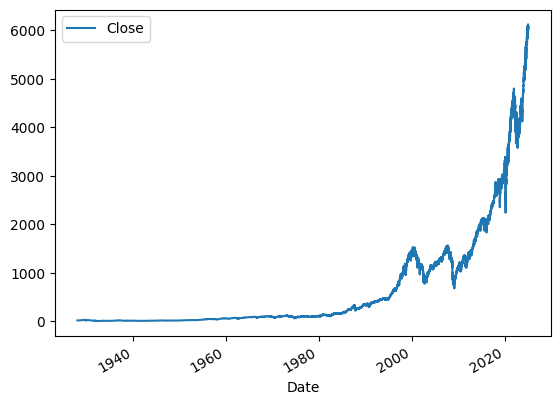

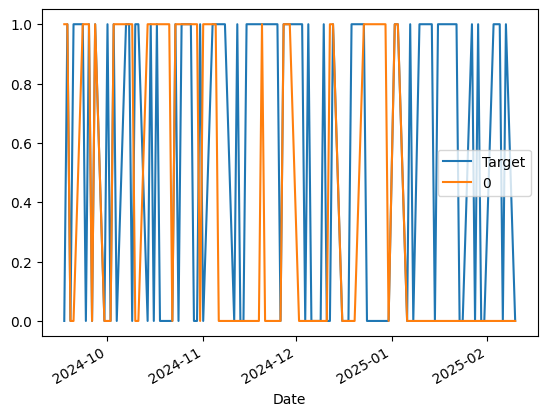

In [ ]:
import yfinance as yf
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score
import pandas as pd

# fetch s&p 500 data
sp500 = yf.Ticker("^GSPC")
sp500_data = sp500.history(period="max")
sp500_data.index = pd.to_datetime(sp500_data.index)

sp500_data.plot.line(y="Close", use_index=True) # plot the closing price

# data cleaning
sp500_data.drop(columns=["Dividends", "Stock Splits"], inplace=True)
sp500_data["Tomorrow"] = sp500_data["Close"].shift(-1)
sp500_data["Target"] = (sp500_data["Tomorrow"] > sp500_data["Close"]).astype(int)
sp500_data = sp500_data.loc["1990-01-01":].copy()  # removing data before 1990


# initializing the model
model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)

# splitting data into training and testing sets
train_data = sp500_data.iloc[:-100]
test_data = sp500_data.iloc[-100:]

predictors = ["Close", "Volume", "Open", "High", "Low"]
model.fit(train_data[predictors], train_data["Target"])

preds = model.predict(test_data[predictors])

# convert predictions to pandas series
preds = pd.Series(preds, index=test_data.index)

precision = precision_score(test_data["Target"], preds)

# concatenate target and predicted values for comparison
combined = pd.concat([test_data["Target"], preds], axis=1)
combined.plot()

# predict and return combined results
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

def backtest(data, model, predictors, start=2500, step=250):  # backtesting function

    all_predictions = []

    # loop through the data to make predictions
    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    
    return pd.concat(all_predictions)

# run backtest and evaluate predictions
predictions = backtest(sp500_data, model, predictors)
precision_score(predictions["Target"], predictions["Predictions"])

predictions["Target"].value_counts() / predictions.shape[0]

# calculate mean close price with different horizons
horizons = [2, 5, 60, 250, 1000]
new_predictors = []

# loop to calculate rolling averages
for horizon in horizons:
    rolling_averages = sp500_data.rolling(horizon).mean()
    
    ratio_column = f"Close_Ratio_{horizon}"
    sp500_data[ratio_column] = sp500_data["Close"] / rolling_averages["Close"]
    
    # trend for the horizon
    trend_column = f"Trend_{horizon}"
    sp500_data[trend_column] = sp500_data.shift(1).rolling(horizon).sum()["Target"]
    
    new_predictors += [ratio_column, trend_column]

# cleaning  table
sp500_data.dropna(subset=sp500_data.columns[sp500_data.columns != "Tomorrow"], inplace=True)

# updated model 
model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)

def predict(train, test, predictors, model): # more confident predictions

    model.fit(train[predictors], train["Target"])
    preds = model.predict_proba(test[predictors])[:, 1]
    preds[preds >= .6] = 1
    preds[preds < .6] = 0
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

predictions = backtest(sp500_data, model, new_predictors)

predictions["Predictions"].value_counts()

# calculate precision score
precision_score(predictions["Target"], predictions["Predictions"])
